In [1]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import numpy as np
HEIGHT = 256
WIDTH = 256

In [5]:
def decode_jpg(file_path):
    jpg = tf.io.read_file(file_path)
    jpg = tf.io.decode_jpeg(jpg, channels=3)
    return jpg

def decode_png(file_path):
    png = tf.io.read_file(file_path)
    png = tf.io.decode_png(png, channels=1)
    return png

def process_path(image_fp, mask_fp):
    image = decode_jpg(image_fp)
    mask = decode_png(mask_fp)
    return image, mask
    
def display(display_list):
    plt.figure(figsize=(10,10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()
    
def resize_images(image, mask):
    image = image[np.newaxis, :, :, :]
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image/255
    mask = mask[np.newaxis, :, :, :]
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = tf.math.round(mask/255)
    return image, mask
    

In [2]:
def split_dataset(dataset):
    train_size = int(DATASET_SIZE * 0.7)
    val_size = test_size = int(DATASET_SIZE * 0.15)
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size)
    val_ds = test_ds.skip(val_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds
    

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate


def improved_unet(W, H):
    input_size = (W, H, 3)
    inputs = Input(input_size)
    print(inputs)
    #W*H*16
    conv1 = conv2D(16, 3, activation = tf.keras.layers.LeakyReLU(alpha=0.01), padding = 'same')(inputs)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv1)
    cont1 = Dropout(0.3)(cont1)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont1)
    conc1 = Add()([conv1, cont1]) #W*H*16
    # W/2 * H/2 * 32
  
    conv2 = conv2D(32, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc1)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv2)
    cont2 = Dropout(0.3)(cont2)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont2)
    conc2 = Add()([conv2, cont2]) #W/2*H/2*32

    conv3 = conv2D(64, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc2)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv3)
    cont3 = Dropout(0.3)(cont3)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont3)
    conc3 = Add()([conv3, cont3]) #W/4*H/4*64

    conv4 = conv2D(128, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc3)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv4)
    cont4 = Dropout(0.3)(cont4)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont4)
    conc4 = Add()([conv4, cont4]) #W/8*H/8*128
 
    conv5 = conv2D(256, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc4)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv5)
    cont5 = Dropout(0.3)(cont5)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont5)
    conc5 = Add()([conv5, cont5]) #W/16*H/16*256

    uconv5 = UpSampling2D(size = (2,2))(conc5)
    uconv5 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv5)
 
    uconv4 = concatenate([uconv5, conc4])
    lconv4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
    lconv4 = conv2D(128, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv4)
    uconv4 = UpSampling2D(size = (2,2))(uconv4)
    uconv4 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
 
    uconv3 = concatenate([uconv4, conc3])
    lconv3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)
    lconv3 = conv2D(64, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3)
    sconv3 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3) 
    sconv3 = UpSampling2D(size = (2,2))(sconv3) 
    uconv3 = UpSampling2D(size = (2,2))(lconv3)
    uconv3 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)

    uconv2 = concatenate([uconv3, conc2])   
    lconv2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    lconv2 = conv2D(32, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2)
    sconv2 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2) 
    sconv2 = Add()([sconv2, sconv3])
    sconv2 = UpSampling2D(size = (2,2))(lconv2)
    uconv2 = UpSampling2D(size = (2,2))(uconv2)
    uconv2 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    
    uconv1 = concatenate([uconv2, conc1])
    uconv1 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1)
    sconv1 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1) 
    sconv1 = Add()([sconv1, sconv2])
    output = conv2D(1, 1, activation = 'sigmoid')(sconv1)
    model = Model(inputs = inputs, outputs = output)
    return model

                          

    

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))
[0. 1.]
(1, 256, 256, 3)
(1, 256, 256, 1)


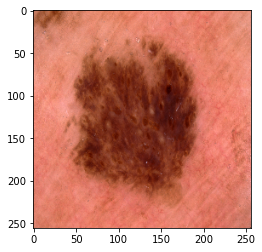

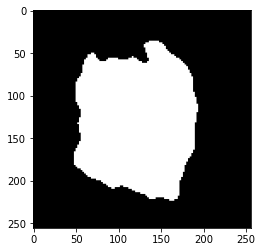

In [27]:


input_images = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/input/*.jpg"))
output_masks = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/truth/*.png"))
DATASET_SIZE = len(input_images)
# print(len(output_masks))

ds  = tf.data.Dataset.from_tensor_slices((input_images, output_masks))
ds = ds.shuffle(len(input_images))
ds = ds.map(process_path)
print(ds.element_spec)

# input_shape = []
# output_shape = []
# for image, mask in ds:
#     input_shape.append(image.shape)
#     output_shape.append(mask.shape)

ds = ds.map(resize_images)
for image, mask in ds.take(1):
#     print(np.unique(image))
    print(np.unique(mask))
    print(image.shape)
    print(mask.shape)
    #image = tf.image.resize(image, (1000, 1512, 1))
    
    plt.imshow(image[0,:,:,:])
    plt.figure()
    plt.imshow(mask[0,:,:,0], cmap='gray')

In [8]:
# import numpy as np
# input_sizes = []
# for i in input_shape:
#     input_sizes.append([i[0],i[1]])


In [ ]:
train_ds, test_ds, val_ds = split_dataset(ds)
print(train_ds.element_spec)
model = improved_unet(HEIGHT, WIDTH)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_ds.repeat(), epochs = 20, steps_per_epoch=20)

(TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None))
Train for 20 steps, validate for 20 steps
Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.6604